In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
from datetime import datetime

In [2]:
#reading our csv file which consists of our data

df = pd.read_csv("C:/Users/USER/Documents/Smart_City/bus_betails.csv", index_col = 'bus_id')
df.head()

,Dummy,pickup_datetime,dropoff_datetime,trip_duration,passenger_count,trip distance,holiday,day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_zip,pickup_location,dropoff_zip,dropoff_location
bus_id,,,,,,,,,,,,,,,,
1,"Sunday, January 01, 2017",01-01-2017 10:18,01-01-2017 10:53,0:35,33,10.0,1,Sunday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur
2,"Monday, January 02, 2017",02-01-2017 21:20,02-01-2017 22:00,0:40,58,10.0,0,Monday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur
3,"Tuesday, January 03, 2017",03-01-2017 14:10,03-01-2017 14:50,0:40,56,10.0,0,Tuesday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur
4,"Wednesday, January 04, 2017",04-01-2017 17:15,04-01-2017 17:58,0:43,78,10.0,0,Wednesday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur
5,"Thursday, January 05, 2017",05-01-2017 15:00,05-01-2017 15:40,0:40,48,10.0,0,Thursday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur


In [3]:
df.dtypes

Dummy                 object
pickup_datetime       object
dropoff_datetime      object
trip_duration         object
passenger_count        int64
trip distance        float64
holiday                int64
day                   object
pickup_latitude      float64
pickup_longitude     float64
dropoff_latitude     float64
dropoff_longitude    float64
pickup_zip             int64
pickup_location       object
dropoff_zip            int64
dropoff_location      object
dtype: object

In [4]:
#parsing only the hour from the date time

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour_of_day'] = df.pickup_datetime.apply(lambda x: x.hour)


In [5]:
#converting the trip duration column which is in date and time format to integer

df['minutes'] = df['trip_duration'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
df['minutes'] = df['minutes'].astype(int)

df.head()

,Dummy,pickup_datetime,dropoff_datetime,trip_duration,passenger_count,trip distance,holiday,day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_zip,pickup_location,dropoff_zip,dropoff_location,hour_of_day,minutes
bus_id,,,,,,,,,,,,,,,,,,
1,"Sunday, January 01, 2017",2017-01-01 10:18:00,01-01-2017 10:53,0:35,33,10.0,1,Sunday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur,10,35
2,"Monday, January 02, 2017",2017-02-01 21:20:00,02-01-2017 22:00,0:40,58,10.0,0,Monday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur,21,40
3,"Tuesday, January 03, 2017",2017-03-01 14:10:00,03-01-2017 14:50,0:40,56,10.0,0,Tuesday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur,14,40
4,"Wednesday, January 04, 2017",2017-04-01 17:15:00,04-01-2017 17:58,0:43,78,10.0,0,Wednesday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur,17,43
5,"Thursday, January 05, 2017",2017-05-01 15:00:00,05-01-2017 15:40,0:40,48,10.0,0,Thursday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur,15,40


In [6]:
#deleting unnecessary columns

df = df.drop(['Dummy', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude', 'pickup_zip', 'dropoff_zip' ], axis=1)

In [7]:
#deriving the basic statistics of our data

df.describe()

,passenger_count,trip distance,holiday,hour_of_day,minutes
count,521.000000,521.000000,521.000000,521.000000,521.000000
mean,53.685221,8.080806,0.067179,14.383877,28.571977
std,20.498986,2.373454,0.250571,5.456687,9.992069
min,5.000000,5.900000,0.000000,5.000000,12.000000
25%,40.000000,5.900000,0.000000,9.000000,21.000000
50%,57.000000,7.900000,0.000000,15.000000,25.000000
75%,68.000000,10.000000,0.000000,19.000000,36.000000
max,95.000000,12.500000,1.000000,23.000000,56.000000


In [8]:
corr = df.corr()
corr

,passenger_count,trip distance,holiday,hour_of_day,minutes
passenger_count,1.000000,-0.040571,0.080876,0.212204,0.424258
trip distance,-0.040571,1.000000,-0.024990,0.040750,0.447603
holiday,0.080876,-0.024990,1.000000,-0.014678,0.110590
hour_of_day,0.212204,0.040750,-0.014678,1.000000,0.194080
minutes,0.424258,0.447603,0.110590,0.194080,1.000000


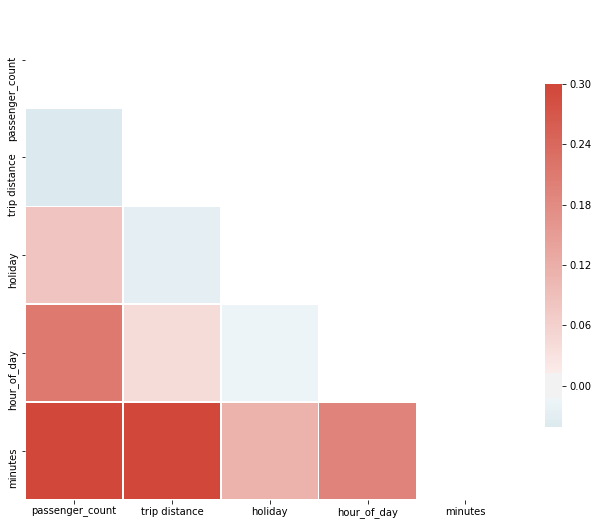

In [9]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 15, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

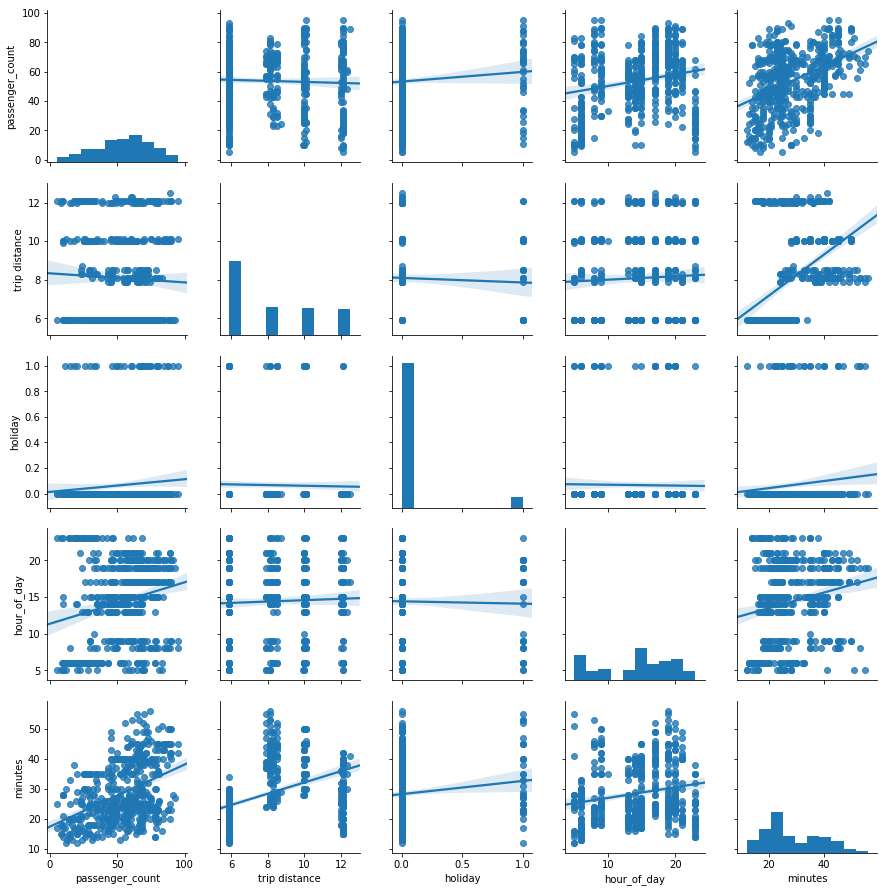

In [10]:
sns.pairplot(df, kind="reg")
plt.show()

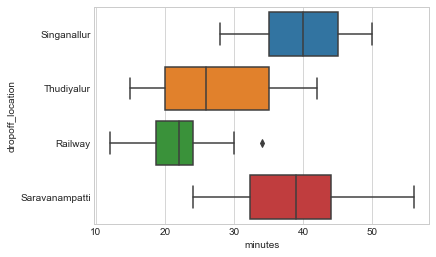

In [11]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="minutes", y="dropoff_location", data=df)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


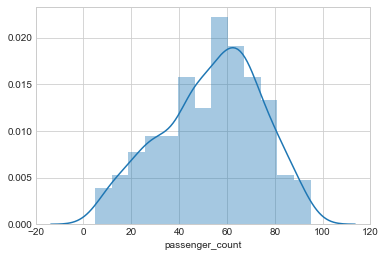

In [12]:
sns.distplot(df.passenger_count.dropna())
plt.show()

In [13]:
day_of_week_dummies = pd.get_dummies(df.day, prefix='day_of_week')

day_of_week_dummies.sample(n=5, random_state=1)

,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
bus_id,,,,,,,
274,0,0,1,0,0,0,0
273,1,0,0,0,0,0,0
330,0,0,0,0,0,1,0
482,0,0,0,1,0,0,0
174,0,0,0,1,0,0,0


In [14]:
hour_of_day_dummies = pd.get_dummies(df.hour_of_day, prefix='hour_of_day')

hour_of_day_dummies.drop(hour_of_day_dummies.columns[0], axis=1, inplace=True)

hour_of_day_dummies.sample(n=5, random_state=1)

,hour_of_day_6,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_17,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_23
bus_id,,,,,,,,,,,,
274,0,0,0,0,0,0,1,0,0,0,0,0
273,0,1,0,0,0,0,0,0,0,0,0,0
330,0,0,0,0,0,0,0,0,1,0,0,0
482,0,0,0,0,0,0,0,0,0,0,0,1
174,0,0,0,0,0,0,0,1,0,0,0,0


In [15]:
dropoff_dummies = pd.get_dummies(df.dropoff_location, prefix='dropoff')

#dropoff_dummies.drop(dropoff_dummies.columns[0], axis=1, inplace=True)

dropoff_dummies.sample(n=5, random_state=1)

,dropoff_Railway,dropoff_Saravanampatti,dropoff_Singanallur,dropoff_Thudiyalur
bus_id,,,,
274,1,0,0,0
273,1,0,0,0
330,1,0,0,0
482,1,0,0,0
174,0,0,0,1


In [16]:
df = pd.concat([df, hour_of_day_dummies, day_of_week_dummies, dropoff_dummies ], axis=1)
df.head()

,passenger_count,trip distance,holiday,day,pickup_location,dropoff_location,hour_of_day,minutes,hour_of_day_6,hour_of_day_8,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,dropoff_Railway,dropoff_Saravanampatti,dropoff_Singanallur,dropoff_Thudiyalur
bus_id,,,,,,,,,,,,,,,,,,,,,
1,33,10.0,1,Sunday,Gandhipuram,Singanallur,10,35,0,0,...,0,0,1,0,0,0,0,0,1,0
2,58,10.0,0,Monday,Gandhipuram,Singanallur,21,40,0,0,...,1,0,0,0,0,0,0,0,1,0
3,56,10.0,0,Tuesday,Gandhipuram,Singanallur,14,40,0,0,...,0,0,0,0,1,0,0,0,1,0
4,78,10.0,0,Wednesday,Gandhipuram,Singanallur,17,43,0,0,...,0,0,0,0,0,1,0,0,1,0
5,48,10.0,0,Thursday,Gandhipuram,Singanallur,15,40,0,0,...,0,0,0,1,0,0,0,0,1,0


In [17]:
df = df.drop(['day', 'hour_of_day', 'dropoff_location', 'pickup_location'], axis=1)
df.head()

,passenger_count,trip distance,holiday,minutes,hour_of_day_6,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_13,hour_of_day_14,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,dropoff_Railway,dropoff_Saravanampatti,dropoff_Singanallur,dropoff_Thudiyalur
bus_id,,,,,,,,,,,,,,,,,,,,,
1,33,10.0,1,35,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,58,10.0,0,40,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,56,10.0,0,40,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
4,78,10.0,0,43,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
5,48,10.0,0,40,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [18]:
feature_cols = ['hour_of_day_6', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
       'hour_of_day_13', 'hour_of_day_14', 'hour_of_day_15',
       'hour_of_day_17', 'hour_of_day_19', 'hour_of_day_20',
       'hour_of_day_21', 'hour_of_day_23', 'day_of_week_Sunday',
       'day_of_week_Monday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday',
       'dropoff_Singanallur', 'dropoff_Thudiyalur',
       'dropoff_Saravanampatti','dropoff_Railway', 'holiday', 'trip distance']

In [19]:
# standardizing the data
from sklearn.preprocessing import MinMaxScaler

scld = MinMaxScaler(feature_range=(0, 1))
arr_scld = scld.fit_transform(df)
df_scld = pd.DataFrame(arr_scld, columns=df.columns)

df_scld.head()

,passenger_count,trip distance,holiday,minutes,hour_of_day_6,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_13,hour_of_day_14,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,dropoff_Railway,dropoff_Saravanampatti,dropoff_Singanallur,dropoff_Thudiyalur
0,0.311111,0.621212,1.0,0.522727,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.588889,0.621212,0.0,0.636364,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.566667,0.621212,0.0,0.636364,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.811111,0.621212,0.0,0.704545,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.477778,0.621212,0.0,0.636364,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

In [21]:
X = df[feature_cols]
y = df.minutes
X_train,X_test,y_train,y_test=train_test_split(X, y, random_state=3)

In [22]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
linreg = lm.fit(X_train, y_train)

In [24]:
print("RSquare Value for test data is-")
np.round(lm.score(X_test, y_test)*100,0)

RSquare Value for test data is-


75.0

In [25]:
print("RSquare Value for train data is-")
np.round(lm.score(X_train, y_train)*100,0)

RSquare Value for train data is-


81.0

In [26]:
from sklearn import metrics

def train_test_rmse(feature_cols):
    X = df[feature_cols]
    y = df.minutes
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [27]:
rmse = (train_test_rmse(['hour_of_day_6', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
       'hour_of_day_13', 'hour_of_day_14', 'hour_of_day_15',
       'hour_of_day_17', 'hour_of_day_19', 'hour_of_day_20',
       'hour_of_day_21', 'hour_of_day_23', 'day_of_week_Sunday',
       'day_of_week_Monday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday',
       'dropoff_Singanallur', 'dropoff_Thudiyalur',
       'dropoff_Saravanampatti','dropoff_Railway', 'holiday', 'trip distance']))

print("RMSE Value using linear regression is-")
rmse

RMSE Value using linear regression is-


4.2757884414513558

In [28]:
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [29]:
#GBmodel = GradientBoostingRegressor()
#param_dist = {'n_estimators':(250, 300, 500), "learning_rate": np.linspace(0.05, 0.15,5),
#               "max_depth": range(3, 5),
#               "min_samples_leaf": range(3, 5)}

#rand = RandomizedSearchCV(GBmodel, param_dist, cv=7,n_iter=10, random_state=5)
#rand.fit(X,y)
#rand.grid_scores_

#print(rand.best_score_)
#rint(rand.best_params_)

In [30]:
params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(**params)

gbr.fit(X_train, y_train)
mse = mean_squared_error(y_test, gbr.predict(X_test))
rmse = np.sqrt(mse)
print("RMSE using Gradient Boosting Regressor is: %.2f" % rmse)

RMSE using Gradient Boosting Regressor is: 3.99


In [31]:

rtest = np.round(gbr.score(X_test, y_test)*100,0)
print("RSquare Value for test data is: %.2f" % rtest)

RSquare Value for test data is: 82.00


In [32]:

rtrain = np.round(gbr.score(X_train, y_train)*100,0)
print("RSquare Value for train data is: %.2f" % rtrain)

RSquare Value for train data is: 92.00


Text(0.5,1,'Feature Importances - Regression')

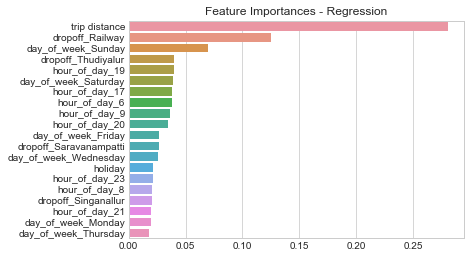

In [33]:
importances = gbr.feature_importances_
importances_by_trees=[tree[0].feature_importances_ for tree in gbr.estimators_]
std = np.std(importances_by_trees,axis=0)
indices = np.argsort(importances)[::-1]

dff = df[feature_cols]
sns.barplot(importances[indices][:20],dff.columns[indices[:20]].values)
plt.title("Feature Importances - Regression")

In [34]:
#feature_cols = ['trip distance', 'holiday', 'hour_of_day_6', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
 #      'hour_of_day_13', 'hour_of_day_14', 'hour_of_day_15', 'hour_of_day_17',
  #     'hour_of_day_19', 'hour_of_day_20', 'hour_of_day_21', 'hour_of_day_23',
   #    'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
    #   'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'dropoff_Saravanampatti','dropoff_Singanallur', 'dropoff_Thudiyalur']



In [35]:
df3 = pd.DataFrame()
X=['Singanallur', 'Thudiyalur', 'Saravanampatti', 'Railway']
Z=[]       
dropoff = raw_input("Enter the Destination: ")

if dropoff != '':
    dropoff_input = 'dropoff_'+str(dropoff)
    df3[dropoff_input] = 1
    Z.append(1)
    #day = int(day)
    X.remove(dropoff)
    for Y in X:
        dropoff_input = 'dropoff_'+str(Y)
        df3[dropoff_input] = 0
        Z.append(0)


df3.loc[-1] = Z
df3.index = df3.index + 1
df3 = df3.sort_index()


#########################################################################


df1 = pd.DataFrame()
X=[6,8,9,10,13,14,15,17,19,20,21,23]
Z=[]

hour = input("Enter the hour of the day (6,8,9,10,13,14,15,17,19,20,21,23)")

if hour != '':
    hour_input = 'hour_of_day_'+str(hour)
    df1[hour_input] = 1
    Z.append(1)
    hour = int(hour)
    X.remove(hour)
    for Y in X:
        hour_input = 'hour_of_day_'+str(Y)
        df1[hour_input] = 0
        Z.append(0)
        
        

df1.loc[-1] = Z
df1.index = df1.index + 1
df1 = df1.sort_index()


####################################################################################



trip_distance = 0

spec = input("Enter Trip Distance:")
holiday = raw_input("Is it a holiday?:")

spec = float(spec)


if holiday == 'yes':
    holiday = 1
    
else: 
    holiday = 0
        
#df4 = [holiday, trip_distance]

df4 = [{'holiday':holiday}]
df6 = [{'trip_distance':spec}]

df5 = pd.DataFrame(df4)
df7 = pd.DataFrame(df6)

########################################################################################


df2 = pd.DataFrame()
X=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
Z=[]       
day = raw_input("Enter the day: ")

if day != '':
    day_input = 'day_of_week_'+str(day)
    df2[day_input] = 1
    Z.append(1)
    #day = int(day)
    X.remove(day)
    for Y in X:
        day_input = 'day_of_week_'+str(Y)
        df2[day_input] = 0
        Z.append(0)


df2.loc[-1] = Z
df2.index = df2.index + 1
df2 = df2.sort_index()


Enter the Destination: Thudiyalur
Enter the hour of the day (6,8,9,10,13,14,15,17,19,20,21,23)14
Enter Trip Distance:12
Is it a holiday?:yes
Enter the day: Sunday


In [36]:
X = pd.concat([df1, df2, df3, df5, df7], axis=1)

X.head()

,hour_of_day_14,hour_of_day_6,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_13,hour_of_day_15,hour_of_day_17,hour_of_day_19,hour_of_day_20,...,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday,dropoff_Thudiyalur,dropoff_Singanallur,dropoff_Saravanampatti,dropoff_Railway,holiday,trip_distance
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,12.0


In [40]:
predict = gbr.predict(X)

In [42]:
print("The ETA for this Journey is: %.2f minutes" % predict)

The ETA for this Journey is: 24.55 minutes
